# <center> Urban Air Pollution Challenge </center>

__Description__

You may have seen recent news articles stating that air quality has improved due to COVID-19. This is true for some locations, but as always the truth is a little more complicated. In parts of many African cities, air quality seems to be getting worse as more people stay at home. For this challenge we’ll be digging deeper into the data, finding ways to track air quality and how it is changing, even in places without ground-based sensors. This information will be especially useful in the face of the current crisis, since poor air quality makes a respiratory disease like COVID-19 more dangerous.

We’ve collected weather data and daily observations from the Sentinel 5P satellite tracking various pollutants in the atmosphere. Your goal is to use this information to predict PM2.5 particulate matter concentration (a common measure of air quality that normally requires ground-based sensors to measure) every day for each city. The data covers the last three months, spanning hundreds of cities across the globe.

__Objective__

The objective of this challenge is to predict PM2.5 particulate matter concentration in the air every day for each city. PM2.5 refers to atmospheric particulate matter that have a diameter of less than 2.5 micrometers and is one of the most harmful air pollutants. PM2.5 is a common measure of air quality that normally requires ground-based sensors to measure. The data covers the last three months, spanning hundreds of cities across the globe.

__Data__

`Train.csv` - contains the target and supporting data for 349 locations. This is the dataset that you will use to train your model.

`Test.csv`- resembles Train.csv but without the target-related columns, and covers 179 different locations.This is the dataset on which you will apply your model to.

`SampleSubmission.csv` - shows the submission format for this competition, with the ‘Place_ID X Date’ column mirroring that of Test.csv and the ‘target’ column containing your predictions. The order of the rows does not matter, but the names of the Place_ID X Date must be correct.

__Variable Definitions:__

Read about the datasets at the following pages:

`Weather Data:` https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25

`Sentinel 5P data:` https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p - all columns begin with the dataset name (eg L3_NO2 corresponds to https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2) - look at the corresponding dataset on GEE for detailed descriptions of the image bands - band names should match the second half of the column titles.

Competition link: https://zindi.africa/hackathons/urban-air-pollution-challenge/data

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from math import sqrt 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold, train_test_split

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# Import Datasets

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub  = pd.read_csv('SampleSubmission.csv')

# Data Pre-processing

In [3]:
train.shape, test.shape, sub.shape

((30557, 82), (16136, 77), (16136, 2))

In [4]:
train.head(2)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.0,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,22.379054,-0.000010,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,NaN,NaN,0.000000,NaN,NaN,NaN,76.536426,38.593017,-61.752587,22.363665,NaN,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.00004,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.6,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.115179,233.313706,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.022017,1148.985447,61.216687,841116.763051,-57.015200,61.402626,-74.457583,33.089495,0.000114,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.000171,0.858446,175.019862,99354.162958,0.059358,5.958538,175.072145,99353.672374,-14.708036,59.624912,-67.693509,28.614804,0.315403,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000150,0.433957,0.00005,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652


In [5]:
test.head(2)

,Place_ID X Date,Date,Place_ID,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,0OS9LVX X 2020-01-02,2020-01-02,0OS9LVX,11.600000,30.200001,0.00409,14.656824,3.956377,0.712605,0.000053,0.000108,0.466171,0.010752,835670.492740,68.099367,1.445658,-95.984984,22.942019,0.000046,6156.074219,0.000007,0.113310,227.467539,0.032071,68.099367,1.445658,-95.984984,22.942019,0.017953,841.142869,155.982981,835625.785337,32.709708,1.898112,-95.987015,22.950150,0.000073,0.032071,68.099367,1.445658,-95.984984,22.942019,0.000088,1.494039,2592.634167,74028.429228,0.032268,6.317523,2593.137433,74023.930722,68.099367,1.445658,-95.984984,22.942019,0.299053,0.466173,835670.492740,68.099367,1.445658,-95.984984,22.942019,0.000221,0.784436,0.000184,-0.140458,0.032071,68.099367,1.445658,-95.984984,22.942019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0OS9LVX X 2020-01-03,2020-01-03,0OS9LVX,18.300001,42.900002,0.00595,15.026544,4.230430,0.661892,0.000050,0.000109,-0.213659,0.028307,835281.882757,75.936844,34.638933,-95.017976,18.539524,0.000045,7311.869141,0.000005,0.110397,227.788713,0.044784,75.936845,34.639165,-95.017596,18.539491,0.019576,1187.570320,922.385833,835225.278332,73.808143,34.720869,-95.017095,18.548551,0.000048,0.040803,75.936813,34.641758,-95.014908,18.539116,0.000074,1.534485,7334.601102,48466.653300,0.046211,8.308433,7902.937546,46345.613031,75.936845,34.639165,-95.017596,18.539491,0.290397,-0.213657,835281.882757,75.936844,34.638933,-95.017976,18.539524,0.000034,0.678988,0.000014,-0.842713,0.040803,75.936813,34.641758,-95.014908,18.539116,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sub.head(2)

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,0
1,0OS9LVX X 2020-01-03,0


In [7]:
#train.isnull().sum()

In [8]:
train['Date'] = pd.to_datetime(train['Date'])
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['Dayofweek'] = train['Date'].dt.dayofweek
train['DayOfyear'] = train['Date'].dt.dayofyear
train['WeekOfyear'] = train['Date'].dt.weekofyear

test['Date'] = pd.to_datetime(test['Date'])
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['Dayofweek'] = test['Date'].dt.dayofweek
test['DayOfyear'] = test['Date'].dt.dayofyear
test['WeekOfyear'] = test['Date'].dt.weekofyear

In [9]:
train.head(2)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle,Month,Day,Dayofweek,DayOfyear,WeekOfyear
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.0,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,22.379054,-0.000010,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,NaN,NaN,0.000000,NaN,NaN,NaN,76.536426,38.593017,-61.752587,22.363665,NaN,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.00004,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118,1,2,3,2,1
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.6,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.115179,233.313706,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.022017,1148.985447,61.216687,841116.763051,-57.015200,61.402626,-74.457583,33.089495,0.000114,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.000171,0.858446,175.019862,99354.162958,0.059358,5.958538,175.072145,99353.672374,-14.708036,59.624912,-67.693509,28.614804,0.315403,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000150,0.433957,0.00005,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652,1,3,4,3,1


In [10]:
train.drop(['Place_ID X Date','Date','Place_ID','target_min','target_max','target_variance','target_count'], axis=1, inplace=True)
test.drop(['Place_ID X Date','Date','Place_ID'], axis=1, inplace=True)

In [11]:
train.shape, test.shape

((30557, 80), (16136, 79))

In [12]:
#train = train.fillna(0) 
#test = test.fillna(0)  

Created these lag features by looking at the feature importances. I couldn't try lag featues for all the features due to time crunch. 

In [13]:
lag_features = ['relative_humidity_2m_above_ground',
                'v_component_of_wind_10m_above_ground',
                'L3_CLOUD_surface_albedo',
                'L3_CO_CO_column_number_density',
                'temperature_2m_above_ground',
                'L3_CLOUD_cloud_optical_depth',
                'L3_O3_O3_column_number_density'
                ]

for feat in lag_features:
    for i in range(3):
        train[feat+'_lag'+str(i+1)] = train[feat].shift(i+1)
        test[feat+'_lag'+str(i+1)] = test[feat].shift(i+1)

In [14]:
X = train.drop(labels=['target'], axis=1)
y = train['target'].values

# Train test split

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=1)

In [16]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((22917, 100), (22917,), (7640, 100), (7640,))

In [17]:
X.head(5)

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle,Month,Day,Dayofweek,DayOfyear,WeekOfyear,relative_humidity_2m_above_ground_lag1,relative_humidity_2m_above_ground_lag2,relative_humidity_2m_above_ground_lag3,v_component_of_wind_10m_above_ground_lag1,v_component_of_wind_10m_above_ground_lag2,v_component_of_wind_10m_above_ground_lag3,L3_CLOUD_surface_albedo_lag1,L3_CLOUD_surface_albedo_lag2,L3_CLOUD_surface_albedo_lag3,L3_CO_CO_column_number_density_lag1,L3_CO_CO_column_number_density_lag2,L3_CO_CO_column_number_density_lag3,temperature_2m_above_ground_lag1,temperature_2m_above_ground_lag2,temperature_2m_above_ground_lag3,L3_CLOUD_cloud_optical_depth_lag1,L3_CLOUD_cloud_optical_depth_lag2,L3_CLOUD_cloud_optical_depth_lag3,L3_O3_O3_column_number_density_lag1,L3_O3_O3_column_number_density_lag2,L3_O3_O3_column_number_density_lag3
0,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,22.379054,-0.000010,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,NaN,NaN,0.000000,NaN,NaN,NaN,76.536426,38.593017,-61.752587,22.363665,NaN,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.000040,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118,1,2,3,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.1151

# Build Model

In [18]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_valid, label=y_valid)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'rmse',
         'learning_rate': 0.05, 
         'num_iterations': 7500,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction': 0.8,
         'bagging_freq': 1,
         'feature_fraction': 0.8
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=100,
                verbose_eval=500,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_valid) 

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 25.5879
[1000]	valid_0's rmse: 24.7623
[1500]	valid_0's rmse: 24.4176
[2000]	valid_0's rmse: 24.2112
[2500]	valid_0's rmse: 24.1062
[3000]	valid_0's rmse: 24.0282
[3500]	valid_0's rmse: 23.9853
[4000]	valid_0's rmse: 23.9608
[4500]	valid_0's rmse: 23.9382
[5000]	valid_0's rmse: 23.9234
[5500]	valid_0's rmse: 23.9061
[6000]	valid_0's rmse: 23.8977
[6500]	valid_0's rmse: 23.8907
[7000]	valid_0's rmse: 23.8862
Early stopping, best iteration is:
[7024]	valid_0's rmse: 23.8861


In [19]:
y_pred

array([72.17571268, 68.8653279 , 72.34612483, ..., 41.21087256,
       76.67375848, 43.98665268])

In [20]:
np.sqrt(mean_squared_error(y_valid, y_pred)) # 26.29975458083641

23.88605440778268

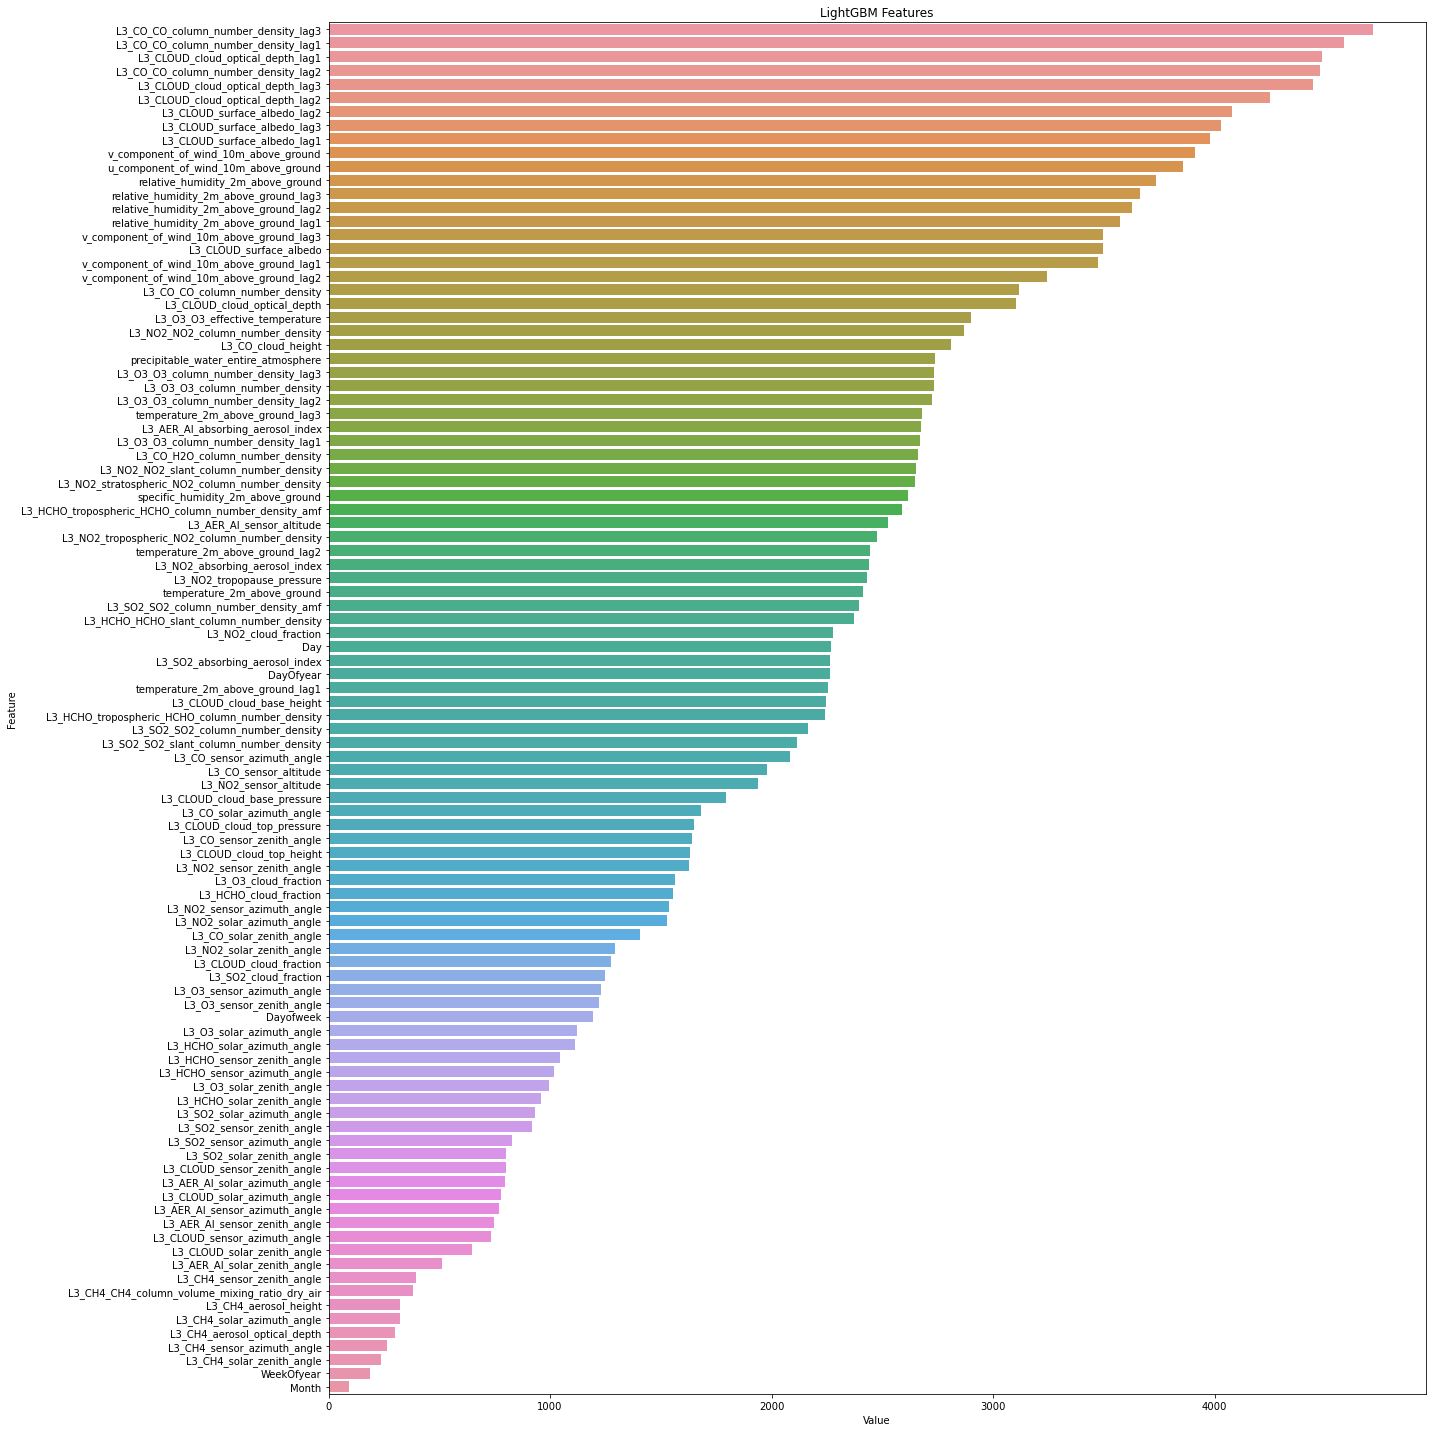

In [21]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(20,20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

# Predict on Test Set

In [22]:
Xtest = test

In [23]:
errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=500,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test) 

    print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
    errlgb.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    p = clf.predict(Xtest)
    
    y_pred_totlgb.append(p)

Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 25.4382
[1000]	valid_0's rmse: 24.4746
[1500]	valid_0's rmse: 23.9745
[2000]	valid_0's rmse: 23.7088
[2500]	valid_0's rmse: 23.5984
[3000]	valid_0's rmse: 23.5046
[3500]	valid_0's rmse: 23.4476
[4000]	valid_0's rmse: 23.3987
[4500]	valid_0's rmse: 23.3767
[5000]	valid_0's rmse: 23.3518
[5500]	valid_0's rmse: 23.3328
[6000]	valid_0's rmse: 23.3187
[6500]	valid_0's rmse: 23.3093
[7000]	valid_0's rmse: 23.3032
[7500]	valid_0's rmse: 23.2984
Did not meet early stopping. Best iteration is:
[7500]	valid_0's rmse: 23.2984
RMSE:  23.298447303841268
Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 28.6719
[1000]	valid_0's rmse: 27.6595
[1500]	valid_0's rmse: 27.2977
[2000]	valid_0's rmse: 27.0212
[2500]	valid_0's rmse: 26.8037
[3000]	valid_0's rmse: 26.7158
[3500]	valid_0's rmse: 26.6472
[4000]	valid_0's rmse: 26.582
[4500]	valid_0's rmse: 26.5513
[5000]	valid_0's rmse: 26.5263

In [24]:
np.mean(y_pred_totlgb,0)

array([62.66950329, 44.17756258, 39.37871175, ..., 51.54551005,
       40.41882477, 37.82100932])

In [25]:
np.mean(errlgb, 0)

24.553374532496083

# Submission

In [26]:
y_pred = np.mean(y_pred_totlgb,0)

In [27]:
sub['target'] = y_pred

In [28]:
sub.head()

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,62.669503
1,0OS9LVX X 2020-01-03,44.177563
2,0OS9LVX X 2020-01-04,39.378712
3,0OS9LVX X 2020-01-05,41.500748
4,0OS9LVX X 2020-01-06,31.186748


In [29]:
sub.to_csv('Output.csv', index=False)